## Load Data

### Original Data

In [1]:
import json 

with open("../annotation.json",'r', encoding='UTF-8') as f:
     load_dict = json.load(f)
        
train_list = load_dict['train']
val_list = load_dict['val']
test_list = load_dict['test']

In [2]:
def get_reports(report_list):
    reports = []
    for i in range(len(report_list)):
        reports.append(report_list[i]['report'])
    return reports

In [3]:
# Load reports into a list
train_reports = get_reports(train_list)
test_reports = get_reports(test_list)
val_reports = get_reports(val_list)
total_reports = train_reports + test_reports + val_reports

In [4]:
for r in [train_reports, test_reports, val_reports]:
    print(len(r))

2069
590
296


## Pre-process

In [5]:
import re
import nltk
import numpy as np
import pandas as pd
nltk.download('stopwords')

import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import PorterStemmer

# Set stopwords
stop_words = set(stopwords.words("english"))

# Stemming
ps = PorterStemmer()

# punctuation
punc = list(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haoyudong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/haoyudong/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [6]:
def divide_to_sentences(reports):
    
    """
    This function is used to divide reports into several sentences.
    
    Args:
        reports: list[str], each str is a report
    
    Return:
        reports_sentences: list[list[str]], each list[str] is the divided sentences of one report
    """
    
    reports_sentences = []
    
    for report in reports:
        text_list = []
        
        text_new = parse_decimal(report)
        text_sentences = text_new.split('.')
        
        for sentence in text_sentences:
            if len(sentence) > 0:
                text_list.append(sentence)

        reports_sentences.append(text_list)    
        
    return reports_sentences

In [7]:
def clean_sentence(reports):
    
    """
    This function is used to clean the reports.
    For example: This image doesn't show some diseases. --> This image does not show some diseases.
    """
    
    clean = []
    for report in reports:
        report_list = []
        
        for text in report:
            text = re.sub(r"n't", " not ", text)
            text = re.sub(r"\'s", " ", text)
            text = re.sub(r"\'ve", " have ", text)
            text = re.sub(r"\'re", " are ", text)
            text = re.sub(r"\'d", " would ", text)
            text = re.sub(r"\'ll", " will ", text)
            # Keep letters only, and convet texts to lower case
            text = re.sub("[^a-z\s]", "", text.lower())
            # Remove punctuations
            text_nopunc = [char for char in text if char not in punc]
            text_nopunc = "".join(text_nopunc)
            wd = []
            for word in text_nopunc.split():
                wd.append(word)
            report_list.append(" ".join(wd))
            
        clean.append(report_list)
        
    return clean

In [8]:
def split_sentence(reports):
    
    """
    Split each sentence into a list of words.
    e.g.,  "a large hiatal hernia is noted" -> ['a', 'large', 'hiatal', 'hernia', 'is', 'noted', '.']
    """
    
    split_sen = []
    
    for report in reports:
        report_list = []
        
        for text in report:
            text_split = text.split()
            text_split.append('.')
            report_list.append(text_split)
            
        split_sen.append(report_list)
        
    return split_sen

In [9]:
def parse_decimal(text):
    
    """
    input: a sentence. e.g. "The size is 5.5 cm."
    return: a sentence. e.g. "The size is 5*5 cm."
    """
    
    find_float = lambda x: re.search("\d+(\.\d+)",x).group()
    text_list = []
    
    for word in text.split():
        try:
            decimal = find_float(word)
            new_decimal = decimal.replace('.', '*')
            text_list.append(new_decimal)
        except:
            text_list.append(word)
            
    return " ".join(text_list)
    

In [10]:
def pre_process(reports):
    
    reports_sentences = divide_to_sentences(reports)
    reports_clean = clean_sentence(reports_sentences)
    reports_split = split_sentence(reports_clean)
    
    return reports_split

In [11]:
train_reports_sentences = divide_to_sentences(train_reports)   # num of reports * num of sentences of each report
train_reports_clean = clean_sentence(train_reports_sentences)  # num of reports * num of sentences of each report
# num of reports * num of sentences of each report * num of words of each sentence
train_reports_split = split_sentence(train_reports_clean)      

test_reports_sentences = divide_to_sentences(test_reports)
test_reports_clean = clean_sentence(test_reports_sentences)
test_reports_split = split_sentence(test_reports_clean)

val_reports_sentences = divide_to_sentences(val_reports)
val_reports_clean = clean_sentence(val_reports_sentences)
val_reports_split = split_sentence(val_reports_clean)

## Bio Dictionary (for IU-XRAY)

In [12]:
split_list = [train_reports_split, test_reports_split, val_reports_split]
clean_list = [train_reports_clean, test_reports_clean, val_reports_clean]

In [13]:
# add each word in the report into the bio dictionary

bio_dictionary = {}

for reports_split in split_list:
    for report in reports_split:
        for sentence in report:
            for word in sentence:
                if word not in bio_dictionary:
                    bio_dictionary[word] = 1
                else:
                    bio_dictionary[word] += 1

In [14]:
# remove stop words

bio_dictionary_remove_stopwords = {}
for key in bio_dictionary:
    if key not in stopwords.words('english'):
        bio_dictionary_remove_stopwords[key] = bio_dictionary[key]
        
sort_bio_dict = sorted(bio_dictionary_remove_stopwords.items(), key=lambda xs: xs[1], reverse=True)


In [15]:
count_1_words = []
for word, count in sort_bio_dict:
    if count == 1:
        count_1_words.append(word)

In [16]:
for reports_split in split_list:
    for report in reports_split:
        for sentence in report:
            unique_word = []
            for word in sentence:
                if word in count_1_words:
                    unique_word.append(word)

## Classes of Organs or Diseases

Please note! This diseases graph is slightly different from the final knowledge graph shown in KG.json.

In the final knowledge graph, we remove 'description' category into 'other' category and remove the classes of 'greater than', 'projecting' and 'have interval'.

In the following cell, we have six objects:

1. organs: a list of organs

2. organ_disease: a dict, each key is an organ, each value is a list of diseases of the organ

3. disease_organ: a dict, each key is a disease or abnormality, each value is its organ

4. organ_synonym: synonym of organ

5. disease_synonym: synonym of disease or abnomality

6. negative_list: a list of negative words

Those objects are all used in the following text process.

In [17]:
organs = ['heart', 'spine', 'pleural', 'bone', 'lung', 'mediastinum','airspace']

organ_disease = {
     'heart': ['cardiomegaly', 'enlarge', 'cardiomediastinal enlarged', 
               'sclerotic', 
               'aorta calcification', 'ectasia', 'tortuosity', 'unfolding'
               'heart opacity', 'bibasilar opacity', 'basilar opacity'
               ],
                 
     'spine': ['scoliosis', 'dextroscoliosis', 'levoscoliosis', 
               'curvature', 'dextrocurvature', 'levocurvature', 
               'lordotic', 
               'degenerative', 'osteopenia', 'deformity', 
               'spondylosis', 'endplate change', 'osteophyt', 
               'spine fusion', 'cervical fusion', 
              ],

     'pleural': ['effusion', 'pleural fluid', 'thickening', 
                 'pneumothorax', 'pleural calcification' 
                ],

     'bone': ['fracture', 'arthritic', 'costochondral calcification', 'fracturedislocation',  
              'bone lesion', 'rib lesion',
              'acromioclavicular widen', 'coracoclavicular widen', 
              'demineralization',
              'acute finding' 
             ],

     'lung': ['tuberculosis',
              'midline', 'fullness',  
              'emphysema', 'pneumonia',  
              'scar', 'nodule', 'edema', 
              'infiltrate','atelectasis', 'engorge',  
              'lung lesion', 'lobe lesion', 'bullae',  
              'vascular congestion', 'obstructive', 
              'inflate',   
              'nodular opacity', 'lobe opacity', 'lung opacity', 'hila opacity', 
              'bronchovascular crowding', 'bronchovascular marking',  
              'pulmonary opacity', 'streaky opacity', 'juxtahilar opacity',  
              'low volume', 'diminished', 'decreased volume', 'volume loss',  
              'collapse', 'retraction', 'deviation', 'consolidation', 'fibrosis',
              'hilar calcification', 'vascular calcification', 'lobe calcification', 
              'interstitial markings','interstitial change','interstitial prominence', 'interstitial opacity', 
              'granuloma calcification', 'granuloma',
              'pulmonary vascularity increase', 'pulmonary vascularity accentuate', 'pulmonary vascularity prominent', 'pulmonary vascularity unremarkable' 
              'hilum prominence', 'artery prominence'
             ],

     'mediastinum': ['mediastinum widen',  
                     'cardiomediastinal enlarged', 
                     'costophrenic blunt', 'eventration',  
                     'hernia', 'calcinosis', 'diaphragm flatten', 'diaphragm opacity',  
                     'mediastinum calcification', 'mediastinum opacity',  
                     'hemidiaphragm elevation', 'hemidiaphragm elevation',  
                     
                    ],

     'airspace': ['airspace disease', 
                  'increased retrosternal airspace', 
                  'airspace opacity', 'cavitary lesion',  
                  'airspace consolidation', 
                  'airspace effusion', 
                  'airspace hyperinflation',
                 ],

     'other':['lymphadenopathy', 'adenopathy', 
              'focal infiltrate', 
              'sequela', 'overlying', 'foreign',   
              'nipple', 'sternotomy', 'artifact', 'valve replacement', 'thoracotomy', 
              'postsurgical', 'clip', 'irregularity', 
              'calcification lymph ', 'breast calcification', 'hemiabdomen calcification', 
              'lingula opacity', 'focal opacity', 'base opacity', 'segment opacity', 
              'cavitation', 'pneumoperitoneum', 
              'picc', 'tube', 
              'bilateral opacity' 
             ],
        
    'description':['chronic', 'greater than', 'abnormality',
                   'suture line', 'fibrosisscar','projecting', 'have interval'] 

}
    


disease_organ = {'cardiomegaly':'heart', 'enlarge':'heart', 'cardiomediastinal enlarged':'heart',
                 'sclerotic':'heart',
                'aorta calcification':'heart', 'ectasia':'heart', 'tortuosity':'heart', 'unfolding':'heart',
                 'bibasilar opacity':'heart', 'basilar opacity':'heart',

                 'scoliosis':'spine','degenerative':'spine', 'osteopenia':'spine', 'deformity':'spine',
                         'spondylosis':'spine', 'endplate change':'spine', 'dextroscoliosis':'spine',
                         'levoscoliosis':'spine', 'curvature':'spine', 'dextrocurvature':'spine','osteophyt':'spine',
                         'spine fusion':'spine', 'cervical fusion':'spine', 'lordotic':'spine',

                 'effusion':'pleural', 'thickening':'pleural', 'pneumothorax':'pleural', 'pleural calcification':'pleural',

                 'fracture':'bone', 'arthritic':'bone', 'costochondral calcification':'bone',  
                  'bone lesion':'bone', 'rib lesion':'bone',  
                 'acromioclavicular widen':'bone', 'coracoclavicular widen':'bone', 'demineralization':'bone',
                 'acute finding':'bone', 'fracturedislocation':'bone',

                 'tuberculosis':'lung', 
                 'midline':'lung', 'fullness':'lung',  
                 'emphysema':'lung', 'pneumonia':'lung',  
                 'scar':'lung', 'nodule':'lung', 'edema':'lung',  
                 'low volume':'lung', 'decreased volume': 'lung', 'diminished':'lung', 'volume loss':'lung', 
                 'infiltrate':'lung','atelectasis':'lung', 'engorge':'lung', 
                 'lung lesion':'lung', 'lobe lesion':'lung', 'bullae':'lung', 
                 'vascular congestion':'lung', 'obstructive':'lung',  
                 'inflate':'lung',  
                 'nodular opacity':'lung', 'lobe opacity':'lung', 'lung opacity':'lung', 'hila opacity':'lung',  
                 'bronchovascular crowding':'lung', 'bronchovascular marking':'lung',  
                 'pulmonary opacity':'lung', 'streaky opacity':'lung', 'juxtahilar opacity':'lung',  
                 'collapse':'lung', 'retraction':'lung', 'deviation':'lung', 'consolidation':'lung', 'fibrosis':'lung', 
                 'hilar calcification':'lung', 'vascular calcification':'lung', 'lobe calcification':'lung',  
                 'interstitial markings':'lung','interstitial change':'lung','interstitial prominence':'lung', 'interstitial opacity':'lung',
                 'granuloma calcification':'lung', 'granuloma':'lung', 
                 'pulmonary vascularity increase':'lung', 'pulmonary vascularity accentuate':'lung', 'pulmonary vascularity prominent':'lung', 'pulmonary vascularity unremarkable':'lung',
                 'hilum prominence':'lung', 'artery prominence':'lung',

                 'mediastinum widen':'mediastinum', 
                 'costophrenic blunt':'mediastinum', 'eventration':'mediastinum', 
                 'hernia':'mediastinum', 'calcinosis':'mediastinum', 'diaphragm flatten':'mediastinum',  
                 'diaphragm opacity':'mediastinum',
                 'mediastinum calcification':'mediastinum', 'mediastinum opacity':'mediastinum', 
                 'hemidiaphragm elevation':'mediastinum', 'hemidiaphragm elevation':'mediastinum',  

                 'airspace disease':'airspace', 
                  'increase retrosternal airspace':'airspace',  
                  'airspace opacity':'airspace', 'cavitary lesion':'airspace',  
                  'airspace consolidation':'airspace',  
                  'airspace effusion':'airspace',  
                  'airspace hyperinflation':'airspace',  

                 'lymphadenopathy':'other', 'adenopathy':'other', 
                  'focal infiltrate':'other',  
                  'sequela':'other', 'overlying':'other', 'foreign':'other',  
                  'nipple':'other', 'sternotomy':'other', 'artifact':'other','valve replacement':'other', 'thoracotomy':'other',  
                  'postsurgical':'other', 'clip':'other', 'irregularity':'other',  
                  'calcification lymph ':'other', 'breast calcification':'other', 'hemiabdomen calcification':'other', 
                  'lingula opacity':'other', 'focal opacity':'other', 'base opacity':'other', 'segment opacity':'other',  
                  'cavitation':'other', 'pneumoperitoneum':'other', 'picc':'other', 'bilateral opacity':'other',
                  'tube':'other',

                'chronic':'description', 'greater than':'description', 'abnormality':'description',
                   'suture line':'description', 'fibrosisscar':'description','projecting':'description',
                 'have interval':'description'

                }

organ_synonym = {'cardiac':'heart', 'aorta':'heart', 'bibasilar':'heart', 'vascular':'heart', 'aortic':'heart',
                 
                 'bony':'bone', 'clavicle':'bone', 'osseous':'bone', 'costochondral':'bone',
                 
                 'lobe':'lung', 'pulmonary':'lung', 'trachea':'lung', 'hilum':'lung', 'perihilar':'lung', 'biapical':'lung', 'hilar':'lung',
                 
                 'thoracic vertebral body':'spine', 'thoracic':'spine', 'thoracolumbar':'spine',
                 
                 'diaphragms': 'mediastinum', 'hemidiaphragms': 'mediastinum', 'costophrenic':'mediastinum', 'mediastinal':'mediastinum',
                 
                 'air space': 'airspace', 'ribs':'rib'}

disease_synonym = {
        'calcified': 'calcification', 'calcific':'calcification', 'calcifications':'calcification',
        'mediastinal':'mediastinum',
        'tortuous':'tortuosity',
        'ectatic':'ectatia',
        'aortic':'aorta',
        'enlargement':'enlarge',  
        'enlarged':'enlarge', 'large':'enlarge',
        'deformities':'deformity',
        'spinal':'spine', 'tspine':'spine',
        'osteophytes':'osteophyt',
        'air space': 'airspace',
        'opacities':'opacity', 'opacification':'opacity',
        'emphysematous':'emphysema',
        'scarring':'scar',
        'bony':'bone',
        'lobes':'lobe',
        'hyperinflate':'hyperinflation',
        'hypoinflation':'hyperinflation',
        'flattened':'flatten', 'flattening':'flatten',
        'diaphragms':'diaphragm',
        'elevated':'elevation',
        'blunted':'blunt', 'blunting':'blunt',
        'widening':'widen', 'widened':'widen',
        'volumes':'volume', 'lower':'low',
        'granulomas':'granuloma', 'granulomatous':'granuloma', 'granulomata':'granuloma',
        'clips':'clip',
        'hypoinflated':'inflate', 'hyperinflated':'inflate', 'hyperexpansion':'inflate',
        'hyperinflation':'inflate', 'hyperexpanded':'inflate',  
        'increased':'increase',
        'atherosclerosis':'sclerotic', 'effusions':'effusion',
        'atherosclerotic':'sclerotic',
        'fractures':'fracture', 'changes':'change',
        'unfolded':'unfolding',
        'obscuration':'opacity', 'obstruction':'opacity',
        'lesions':'lesion', 
        'engorged':'engorge', 'engorgement':'engorge', 
        'findings':'finding', 'abnormalities':'abnormality',
        'infiltrates':'infiltrate', 'masses':'mass', 'consolidations':'consolidation',
        'tuberculous':'tuberculosis', 'cavitations':'cavitation', 'fracturedislocations':'fracturedislocation',
        'hila':'hilum', 'arteries':'artery', 'atelectatic':'atelectasis',
}


negative_list = ['no ', 'not ', 'free of', 'negative', 'without', 'clear of'] 

## find disease sentence

In [18]:
def replace_synonym(sentence):
    
    sentence_list = sentence.split(' ')
    for i in range(len(sentence_list)):
        if sentence_list[i] in disease_synonym:
            sentence_list[i] = disease_synonym[sentence_list[i]]
            
    sentence = ' '.join(sentence_list)
    
    return sentence, sentence_list

In [19]:
def replace_disease_synonym(sentence):
    
    sentence_list = sentence.split(' ')
    for i in range(len(sentence_list)):
        if sentence_list[i] in disease_synonym:
            sentence_list[i] = disease_synonym[sentence_list[i]]
            
    sentence = ' '.join(sentence_list)
    
    return sentence, sentence_list

In [20]:
def delete_negative(sentence_organs, sentence_diseases, sentence):
    
    if len(sentence_diseases) == 0:
        return sentence_organs, sentence_diseases

    for negative_words in negative_list:
        if negative_words in sentence:
            ne_len = len(negative_words)
            app_index = sentence.find(negative_words)
            temp_sentence = sentence[ne_len+app_index:]
            
            temp_sentence_word_set = set(temp_sentence.split(' '))
            
            count = 0
            sentence_diseases_copy = sentence_diseases.copy()
            for disease in sentence_diseases_copy:
                disease_set = set(disease.split(' '))
                
                if disease_set.issubset(temp_sentence_word_set):
                    disease_index = sentence_diseases_copy.index(disease)
                    
                    sentence_organs.pop(disease_index - count)
                    sentence_diseases.pop(disease_index - count)
                    
                    count += 1
                    
    return sentence_organs, sentence_diseases

In [21]:
# This part is different from synonym substitution because diseases are described by more than one word

def associate_same_disease(sentence_diseases): 
    if 'enlarge' in sentence_diseases:  # enlarge a special case which is not in synonym substitution, but placed here
        idx = sentence_diseases.index('enlarge')
        sentence_diseases[idx] = 'cardiomegaly'
    
    if 'cardiomediastinal enlarged' in sentence_diseases:
        idx = sentence_diseases.index('cardiomediastinal enlarged')
        sentence_diseases[idx] = 'cardiomegaly'
        
    if 'pulmonary vascularity accentuate' in sentence_diseases:
        idx = sentence_diseases.index('pulmonary vascularity accentuate')
        sentence_diseases[idx] = 'pulmonary vascularity increase'
        
    if 'pulmonary vascularity prominent' in sentence_diseases:
        idx = sentence_diseases.index('pulmonary vascularity prominent')
        sentence_diseases[idx] = 'pulmonary vascularity increase'
        
    return sentence_diseases

In [22]:
def remove_special_case(sentence_organs, sentence_diseases):
    
    if 'airspace consolidation' in sentence_diseases and 'consolidation' in sentence_diseases:
        idx = sentence_diseases.index('consolidation')
        sentence_diseases.pop(idx)
        sentence_organs.pop(idx)
        
    if 'airspace hyperinflation' in sentence_diseases and 'hyperinflation' in sentence_diseases:
        idx = sentence_diseases.index('hyperinflation')
        sentence_diseases.pop(idx)
        sentence_organs.pop(idx)
        
    if 'airspace effusion' in sentence_diseases and 'effusion' in sentence_diseases:
        idx = sentence_diseases.index('effusion')
        sentence_diseases.pop(idx)
        sentence_organs.pop(idx)
        
    if 'granuloma calcification' in sentence_diseases and 'granuloma' in sentence_diseases:
        idx = sentence_diseases.index('granuloma')
        sentence_diseases.pop(idx)
        sentence_organs.pop(idx)

    return sentence_organs, sentence_diseases
    

In [23]:
# Find disease in reports
def find_diseases_organs(reports_list):

    organs_list = []
    diseases_list = []
    reports_replaced_list = []
    reports_replaced_split_list = []
    
    # step1: 进行同义词替换，然后分词
    for report in reports_list:
        report_replaced_list = []
        report_replaced_split_list = []
        
        for sentence in report:
            replaced_sentence, replaced_sentence_split = replace_synonym(sentence)
            report_replaced_list.append(replaced_sentence)
            report_replaced_split_list.append(replaced_sentence_split)
            
        reports_replaced_list.append(report_replaced_list)
        reports_replaced_split_list.append(report_replaced_split_list)
    
    # step2: 找疾病及对应器官
    for i in range(len(reports_replaced_list)):
        report = reports_replaced_list[i]
        report_word = reports_replaced_split_list[i]
        
        report_organs = []
        report_diseases = []
        
        for j in range(len(report)):
            sentence = report[j]
            sentence_word = report_word[j]
            sentence_word_set = set(sentence_word)
            
            sentence_organs = []
            sentence_diseases = []
            
            for key in disease_organ:
                key_set = set(key.split(' '))
                if key_set.issubset(sentence_word_set):
                    sentence_organs.append(disease_organ[key])
                    sentence_diseases.append(key)
            
            # step3: 剔除特殊的airspace/granuloma情况：
            sentence_organs, sentence_diseases = remove_special_case(sentence_organs, sentence_diseases)
            
            # step4: 进行同义疾病合并，如心脏肥大
            sentence_diseases = associate_same_disease(sentence_diseases)
            
            # step5: 剔除否定词后的情况
            sentence_organs, sentence_diseases = delete_negative(sentence_organs, sentence_diseases, sentence)
            report_organs.append(sentence_organs)
            report_diseases.append(sentence_diseases)
            
        organs_list.append(report_organs)
        diseases_list.append(report_diseases)
        
    return organs_list, diseases_list


In [24]:
# create dataframe

train_df = pd.DataFrame(train_list)
test_df = pd.DataFrame(test_list)
val_df = pd.DataFrame(val_list)

train_df['split_by_sentence'] = train_reports_clean
test_df['split_by_sentence'] = test_reports_clean
val_df['split_by_sentence'] = val_reports_clean

In [25]:
train_df.iloc[0]

id                                                     CXR2384_IM-0942
report               The heart size and pulmonary vascularity appea...
image_path              [CXR2384_IM-0942/0.png, CXR2384_IM-0942/1.png]
split                                                            train
split_by_sentence    [the heart size and pulmonary vascularity appe...
Name: 0, dtype: object

In [26]:
train_organs_list, train_diseases_list = find_diseases_organs(train_reports_clean)
test_organs_list, test_diseases_list = find_diseases_organs(test_reports_clean)
val_organs_list, val_diseases_list = find_diseases_organs(val_reports_clean)

train_df['organs_list'] = train_organs_list
test_df['organs_list'] = test_organs_list
val_df['organs_list'] = val_organs_list

train_df['diseases_list'] = train_diseases_list
test_df['diseases_list'] = test_diseases_list
val_df['diseases_list'] = val_diseases_list

In [27]:
train_df.iloc[0]

id                                                     CXR2384_IM-0942
report               The heart size and pulmonary vascularity appea...
image_path              [CXR2384_IM-0942/0.png, CXR2384_IM-0942/1.png]
split                                                            train
split_by_sentence    [the heart size and pulmonary vascularity appe...
organs_list                [[], [heart, mediastinum], [], [], [spine]]
diseases_list        [[], [cardiomegaly, hernia], [], [], [degenera...
Name: 0, dtype: object

## Create Data Pool

### Disease pool

In [28]:
diseases_pool = {}
for key in disease_organ:
    pool_key = key + '-' + disease_organ[key]
    diseases_pool[pool_key] = []

In [29]:
disease_type = []

for i in range(len(train_df)):
    
    item = train_df.iloc[i]
    organs = item['organs_list']
    diseases = item['diseases_list']
    sentences = item['split_by_sentence']
    report_disease = []
    
    for j in range(len(sentences)):
        assert len(organs[j]) == len(diseases[j])
        organ = organs[j]
        disease = diseases[j]
        sentence = sentences[j]
        sentence_disease = []
        
        if len(organ) > 0:
            for t in range(len(organ)):
                key = disease[t] + '-' + organ[t]
                sentence_disease.append(key)
                if sentence not in diseases_pool[key]:
                    diseases_pool[key].append(sentence)
        report_disease.append(sentence_disease)
    disease_type.append(report_disease)

In [30]:
train_df['disease_type'] = disease_type

In [31]:
train_df.iloc[0]

id                                                     CXR2384_IM-0942
report               The heart size and pulmonary vascularity appea...
image_path              [CXR2384_IM-0942/0.png, CXR2384_IM-0942/1.png]
split                                                            train
split_by_sentence    [the heart size and pulmonary vascularity appe...
organs_list                [[], [heart, mediastinum], [], [], [spine]]
diseases_list        [[], [cardiomegaly, hernia], [], [], [degenera...
disease_type         [[], [cardiomegaly-heart, hernia-mediastinum],...
Name: 0, dtype: object

### Normal Pool

In [32]:
positive_list = [
    'intact', 'clear', # and no clear of
    'aerated', 'stable', 'unchanged', 'obtain', 'normal'
]

negative_list = ['no ', 'not ', 'free of', 'negative', 'unremarkable', 'without', 'clear of']

organs_tissue_description = ['heart', 'cardiomediastinal', 'venous', 'coronary', 'vasculature',
          'spine', 'pleural',
                 'bone', 'skeletal structure', 'rib', 'ankle mortise', 'sacroiliac',
                 'lung', 'tracheostomy tube', 'hilar',
                 'mediastinum','airspace',  'abdomen',
                 'views', 'xxxx', 'tissue', 'mass', 'exam', 'lateral', 'nodule', 'density', 'change']

general_disease = ['calcification', 'opacity', 'free air', 
                   'focal consolidation', 'cardiopulmonary disease', 'air space disease', 'apical disease']


In [33]:
def replace_organ_synonym(sentence):
    
    sentence_list = sentence.split(' ')
    for i in range(len(sentence_list)):
        if sentence_list[i] in organ_synonym:
            sentence_list[i] = organ_synonym[sentence_list[i]]
            
    sentence = ' '.join(sentence_list)
    
    return sentence

In [34]:
def check_positive(sentence):
    
    key = ''
    
    # check whether contains normal description words
    for pos_word in positive_list:
        if pos_word in sentence:
            key += pos_word
    
    # if not, return key=[]
    if len(key) == 0:
        return []
    else:
        key += '-'

    # check corresponding organs or tissue
    for organ in organs_tissue_description:
        if organ in sentence:
            key += organ
            key += '_'
    if key[-1] == '_':
        key = key[:-1]
    
    # check whether have corresponding organs
    key_list = key.split('-')
    if len(key_list[1]) == 0:
        key += 'other'
    
    return [key]
    

In [35]:
def check_no_negative(sentence):
    
    """
    This function is to set key for each sentence. 
    
    Normal description key：positive-organ1_organ2

    Negative normal description key: no-disease1_organ1-disease2_organ2
    
    """
    
    key_list = []
    key = ''
    
    # iterate negative words
    for negative_words in negative_list:
        
        has_key = ''
        
        # if has negative words，further check diseases and organs
        if negative_words in sentence:
            
            # according to the position of negative words, get the temp sentence after the word
            ne_len = len(negative_words)
            app_index = sentence.find(negative_words)
            temp_sentence = sentence[ne_len+app_index:]
        
            # if the number of sentence after negative words, then the temp sentence is the whole sentence
            if len(temp_sentence) == 0:
                temp_sentence = sentence
                
            # get the set of words of the temp sentence
            temp_sentence_word_set = set(temp_sentence.split(' '))
            
            # iterate disease，if has disease，set key
            for disease in disease_organ:
                disease_set = set(disease.split(' '))
                if disease_set.issubset(temp_sentence_word_set):
                    if len(key) == 0:
                        key = 'no-' + disease + '_' + disease_organ[disease]
                    else:
                        key = key + '-' + disease + '_' + disease_organ[disease]
                    has_key = 'good'
                    
            if len(key) > 0:
                key_list.append(key)
            
            # if find no diseases，iterate over organ
            # if the temp sentence has organ，then set key
            # if not, turn the whole temp sentence into the whole sentence and check organ
            if len(has_key) == 0:
                for organ in organs_tissue_description:
                    if organ in temp_sentence:
                        key = 'no-None-' + organ
                        key_list.append(key)
                        has_key = 'good'
                    else:
                        temp_sentence = sentence
                        if organ in temp_sentence:
                            key = 'no-None-' + organ
                            key_list.append(key)
                            has_key = 'good'
                        
            # if find no organ, then iterate over general diseases
            # if the temp sentence has disease, set key
            if len(has_key) == 0:
                temp_sentence_word_set = set(temp_sentence.split(' '))
                for disease in general_disease:
                    disease_set = set(disease.split(' '))
                    if disease_set.issubset(temp_sentence_word_set):
                        key = 'no-' + disease + '-None'
                        key_list.append(key)
                        has_key = 'good'
                 
            # if find no general disease，set key to no-unknown-unknown
            if len(has_key) == 0:
                key = 'no-unknown-unknown'
                key_list.append(key)
                
    return key_list

In [36]:
normal_list = []

count = 0

for i in range(len(train_df)):
    
    item = train_df.iloc[i]
    itme_organs = item['organs_list']
    itme_diseases = item['diseases_list']
    itme_sentences = item['split_by_sentence']
    
    report_normal_list = []
    
    for j in range(len(itme_sentences)):
        
        if len(itme_organs[j]) == 0:
            cur_sentence, _ = replace_disease_synonym(itme_sentences[j])
            cur_sentence = replace_organ_synonym(cur_sentence)
            key = check_positive(cur_sentence)  # if find no normal description words, return empty
            
            # if find no normal description, then check if has negative description
            if len(key) == 0:
                key = check_no_negative(cur_sentence)
            
            # mark the sentences which contains only one or two words
            cur_sentence_split = cur_sentence.split(' ')
            if len(cur_sentence_split) == 1:
                key = ['length_one']
            elif len(cur_sentence_split) == 2:
                key = ['length_two']
            
            if len(key) == 0:
                count += 1
        
        # set the key to an empty list if the sentence has diseases
        else:
            key = []
        
        report_normal_list.append(key)
            
    normal_list.append(report_normal_list)

In [37]:
normal_pool = {}

for i in range(len(normal_list)):
    item = train_df.iloc[i]
    normal_report = normal_list[i]
    diseases = item['diseases_list']
    sentences = item['split_by_sentence']
    
    for j in range(len(normal_report)):
        key_list = normal_report[j]
        for key in key_list:
            if key not in normal_pool:
                normal_pool[key] = []
                
            if sentences[j] not in normal_pool[key]:
                normal_pool[key].append(sentences[j])
    

In [38]:
train_df['normal_type'] = normal_list

## Count Disease

In [39]:
def check_disease(df):
    # add disease column, add organs_with_disease column
    has_disease = []  # to add in dataframe
    disease_description_list = []  # overal

    organs_disease = [] # to add in dataframe
    organs_with_disease_list = []  # overal

    for item_idx in range(len(df)):
        item = df['diseases_list'][item_idx]
        item_organs = df['organs_list'][item_idx]
        item_organs_with_disease = []
        count_disease = 0

        for sentence_idx in range(len(item)):
            sentence = item[sentence_idx]
            sentence_organs = item_organs[sentence_idx]
            sentence_organs_with_disease = []

            for disease_idx in range(len(sentence)):
                disease = sentence[disease_idx]

                if isinstance(disease, str):
                    count_disease += 1
                    disease_description_list.append(disease)
                    try:
                        sentence_organs_with_disease.append(sentence_organs[disease_idx])
                    except:
                        pass

            item_organs_with_disease.append(sentence_organs_with_disease)
        organs_disease.append(item_organs_with_disease)

        if count_disease == 0:
            has_disease.append(0)
        else:
            has_disease.append(count_disease)

    df['has_disease'] = has_disease  # has_disease

    for item in organs_disease:
        for sentence in item:
            if len(sentence) > 0:
                for organ in sentence:
                    organs_with_disease_list.append(organ)
                    
    return disease_description_list, organs_with_disease_list

In [40]:
train_df.head()

,id,report,image_path,split,split_by_sentence,organs_list,diseases_list,disease_type,normal_type
0,CXR2384_IM-0942,The heart size and pulmonary vascularity appea...,"[CXR2384_IM-0942/0.png, CXR2384_IM-0942/1.png]",train,[the heart size and pulmonary vascularity appe...,"[[], [heart, mediastinum], [], [], [spine]]","[[], [cardiomegaly, hernia], [], [], [degenera...","[[], [cardiomegaly-heart, hernia-mediastinum],...","[[normal-heart_lung], [], [no-airspace disease..."
1,CXR2926_IM-1328,Cardiac and mediastinal contours are within no...,"[CXR2926_IM-1328/0.png, CXR2926_IM-1328/1.png]",train,[cardiac and mediastinal contours are within n...,"[[], [], []]","[[], [], []]","[[], [], []]","[[normal-heart_mediastinum], [clear-lung], [in..."
2,CXR1451_IM-0291,Left lower lobe calcified granuloma. Heart siz...,"[CXR1451_IM-0291/0.png, CXR1451_IM-0291/1.png]",train,"[left lower lobe calcified granuloma, heart si...","[[lung, lung], [], [], [lung], [lung]]","[[lobe calcification, granuloma calcification]...","[[lobe calcification-lung, granuloma calcifica...","[[], [normal-heart], [no-effusion_pleural-pneu..."
3,CXR2887_IM-1289,The cardiomediastinal silhouette is normal in ...,"[CXR2887_IM-1289/0.png, CXR2887_IM-1289/1.png]",train,[the cardiomediastinal silhouette is normal in...,"[[], [lung], [], [bone]]","[[], [lung opacity], [], [fracture]]","[[], [lung opacity-lung], [], [fracture-bone]]","[[normal-cardiomediastinal], [], [no-effusion_..."
4,CXR1647_IM-0424,"The lungs are clear bilaterally. Specifically,...","[CXR1647_IM-0424/0.png, CXR1647_IM-0424/1.png]",train,"[the lungs are clear bilaterally, specifically...","[[], [], [], []]","[[], [], [], []]","[[], [], [], []]","[[clear-lung_lateral], [no-effusion_pleural-pn..."


In [41]:
train_disease_description_list, train_organs_with_disease_list = check_disease(train_df)
val_disease_description_list, val_organs_with_disease_list = check_disease(val_df)
test_disease_description_list, test_organs_with_disease_list = check_disease(test_df)

In [42]:
def count_sentence(df):

    count_sentence_has_disease = 0
    count_sentence = 0

    for item in df['diseases_list'].tolist():
        count_sentence += len(item)
        for sentence in item:
            for value in sentence:
                if isinstance(value, str):
                    count_sentence_has_disease += 1
                    continue
                    
    return count_sentence_has_disease, count_sentence

In [43]:
train_count_sentence_has_disease, train_count_sentence = count_sentence(train_df)
print("train: has_disease: {}, total: {}".format(train_count_sentence_has_disease, train_count_sentence))

val_count_sentence_has_disease, val_count_sentence = count_sentence(val_df)
print("val: has_disease: {}, total: {}".format(val_count_sentence_has_disease, val_count_sentence))

test_count_sentence_has_disease, test_count_sentence = count_sentence(test_df)
print("test: has_disease: {}, total: {}".format(test_count_sentence_has_disease, test_count_sentence))

train: has_disease: 3753, total: 9712
val: has_disease: 532, total: 1360
test: has_disease: 733, total: 2534


In [44]:
# count each disease
def count_disease(disease_list):
    
    disease_description_count = {}

    for disease in disease_list:
        if disease not in disease_description_count:
            disease_description_count[disease] = 1
        else:
            disease_description_count[disease] += 1

    # sort the dict
    sorted_disease_description_count = {k: v for k, v in sorted(disease_description_count.items(), key=lambda item: item[1], reverse=True)}

    return sorted_disease_description_count

In [45]:
train_sorted_disease_description_count = count_disease(train_disease_description_list)
val_sorted_disease_description_count = count_disease(val_disease_description_list)
test_sorted_disease_description_count = count_disease(test_disease_description_list)

In [46]:
# show diseases in train

import matplotlib.pyplot as plt
def plot_disease(sorted_disease_description_count, mode, min_value=-1):

    tmp = {k:sorted_disease_description_count[k] for k in sorted_disease_description_count \
           if sorted_disease_description_count[k] > min_value}
    
    keys_ = list(tmp.keys())
    values_ = list(tmp.values())
    
    keys = []
    values = []
    
    count = 0
    
    for i in range(len(keys_)):
        value = values_[i]
        key = keys_[i]
        if value < 5 and len(keys_) - i > 7:
            count += 1
            if count < 4:
                values.append(0)
                keys.append('.'*count)
            pass
        else:
            values.append(value)
            keys.append(key)
    
    
    plt.figure(figsize=(40, 10))
    plt.bar(keys, values)
    plt.xticks(rotation=90)

    for a,b in zip(keys,values):
        plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=8)
    plt.title(mode)  

120


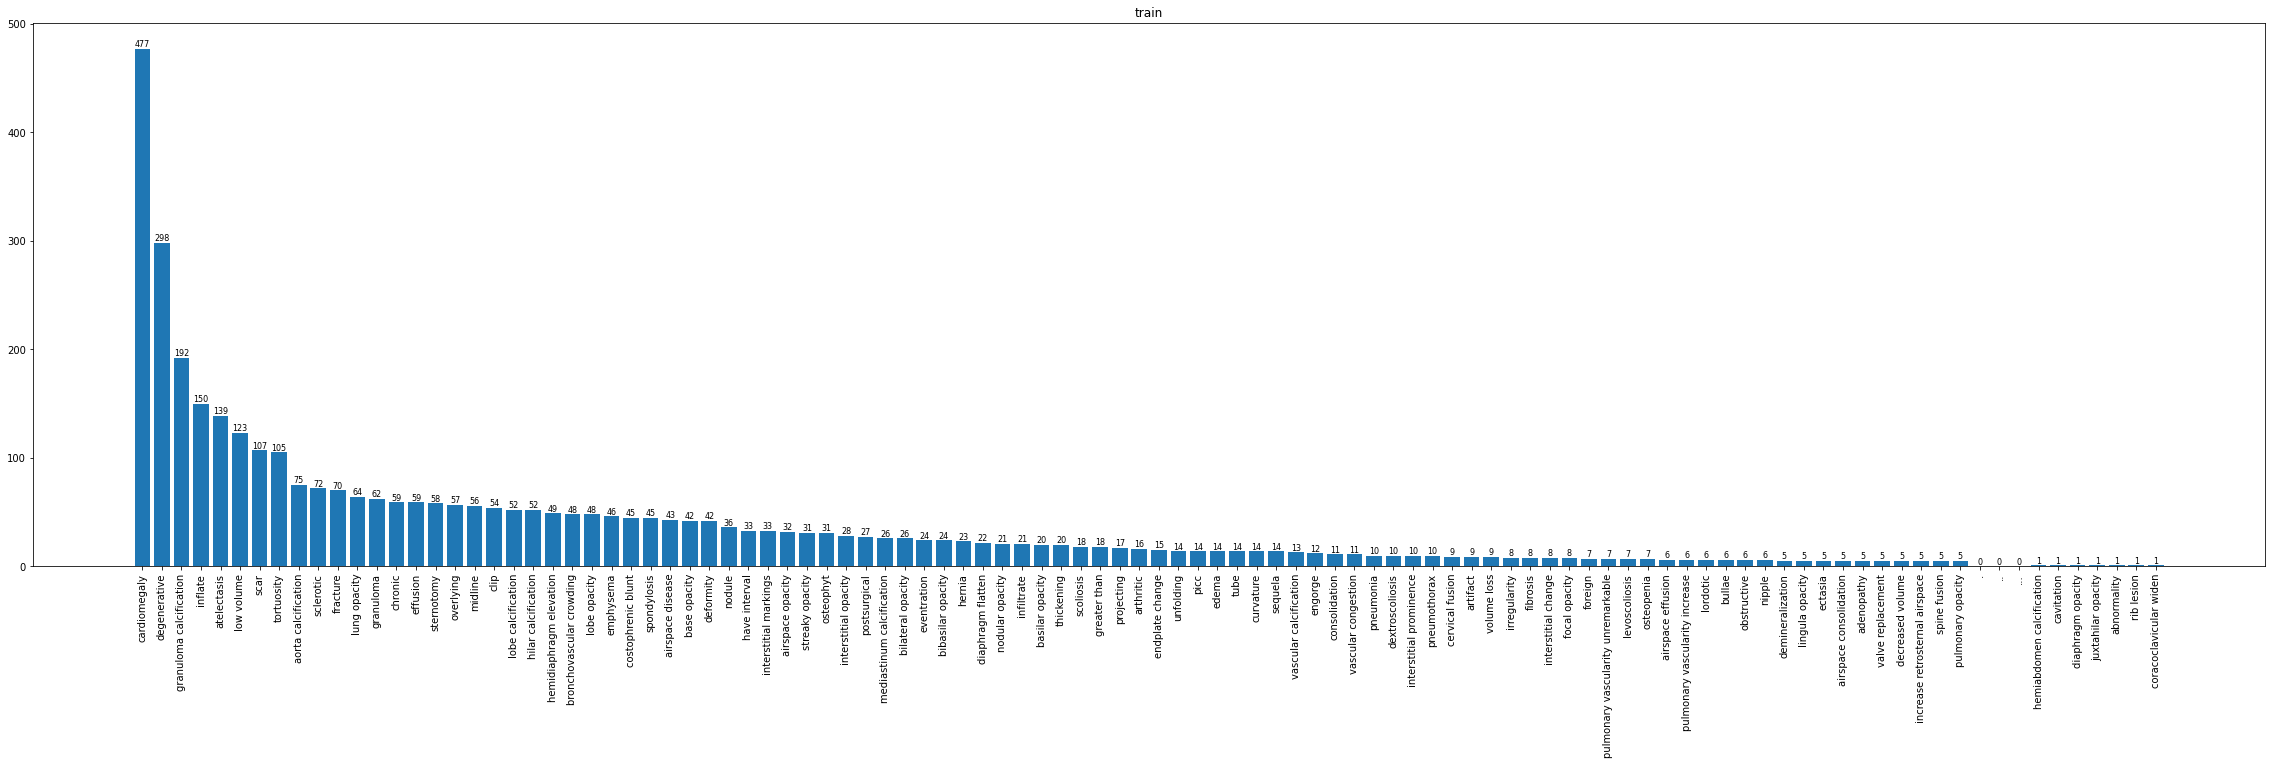

In [47]:
# train

plot_disease(train_sorted_disease_description_count, 'train')
print(len(train_sorted_disease_description_count))

120


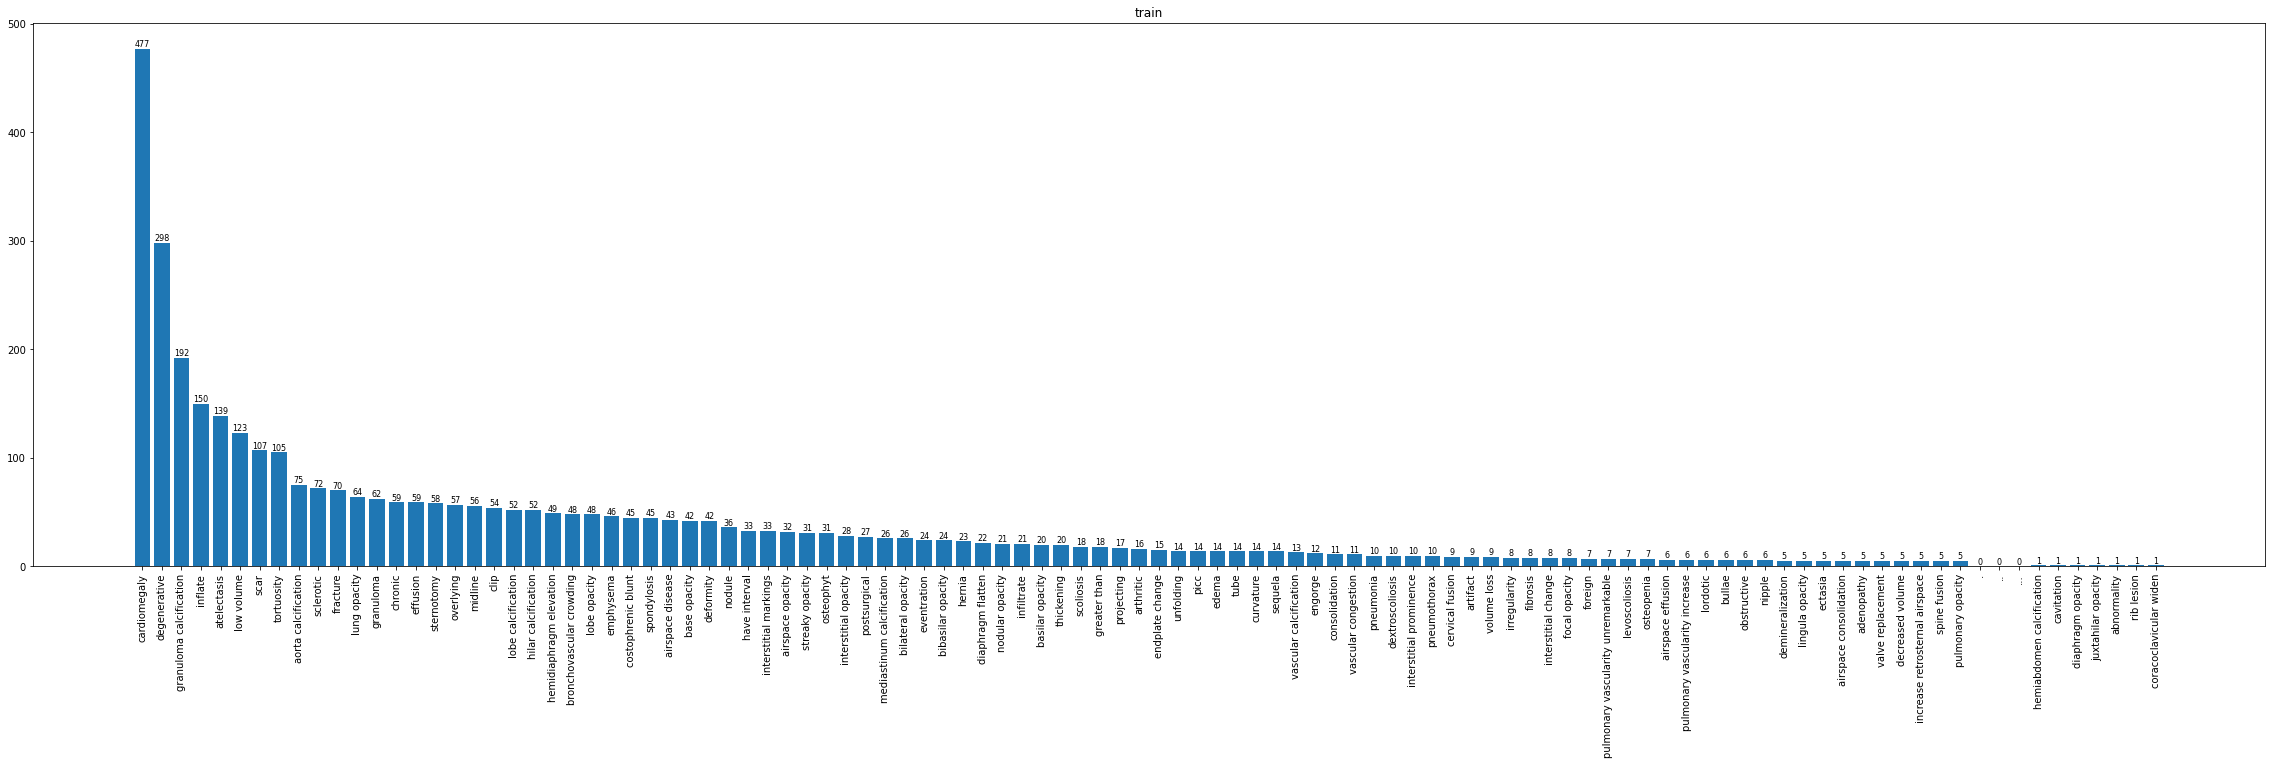

In [48]:
# train

plot_disease(train_sorted_disease_description_count, 'train')
print(len(train_sorted_disease_description_count))

In [49]:
def disease_histogram(dataframe):
    d_all = dataframe['diseases_list']
    d_set = {}
    for single_d in d_all:
        for d in single_d:
            for sd in d:
                if sd not in d_set:
                    d_set[sd] = 1
                else:
                    d_set[sd] += 1
    sort_d_set = {k: v for k, v in sorted(d_set.items(), key=lambda item: item[1], reverse=True)}
    return sort_d_set

def disease_histogram_asc(dataframe):
    d_all = dataframe['diseases_list']
    d_set = {}
    for single_d in d_all:
        for d in single_d:
            for sd in d:
                if sd not in d_set:
                    d_set[sd] = 1
                else:
                    d_set[sd] += 1
    sort_d_set = {k: v for k, v in sorted(d_set.items(), key=lambda item: item[1], reverse=False)}
    return sort_d_set

In [50]:
# Create new pool by sentence-level disease

def disease_pool_sent_no_order(dataframe):
    d_all = dataframe['disease_type']
    d_set = {}
    for i, single_d in enumerate(d_all):
        for j, d in enumerate(single_d):
            if len(d) == 0:
                continue
            total_d = []
            for sd in d:
                total_d.append(sd)
            total_d_str = ""
            total_d.sort()
            for d in total_d:
                total_d_str += d + '-'
            total_d_str = total_d_str[:-1]
            target_sent = dataframe.iloc[i]['split_by_sentence'][j]
            if total_d_str not in d_set:
                d_set[total_d_str] = [target_sent]
            else:
                d_set[total_d_str].append(target_sent)
    return d_set

In [51]:
sent_disease_pool = disease_pool_sent_no_order(train_df)

In [52]:
len(sent_disease_pool)

434

In [53]:
sent_disease_count = {k: len(sent_disease_pool[k]) for k in sent_disease_pool}

In [54]:
def disease_histogram_sent_no_order(dataframe):
    pool = disease_pool_sent_no_order(dataframe)
    count = {k: len(pool[k]) for k in pool}
    return {k: v for k, v in sorted(count.items(), key=lambda item: item[1], reverse=True)}

def disease_histogram_sent_no_order_asc(dataframe):
    pool = disease_pool_sent_no_order(dataframe)
    count = {k: len(pool[k]) for k in pool}
    return {k: v for k, v in sorted(count.items(), key=lambda item: item[1], reverse=False)}

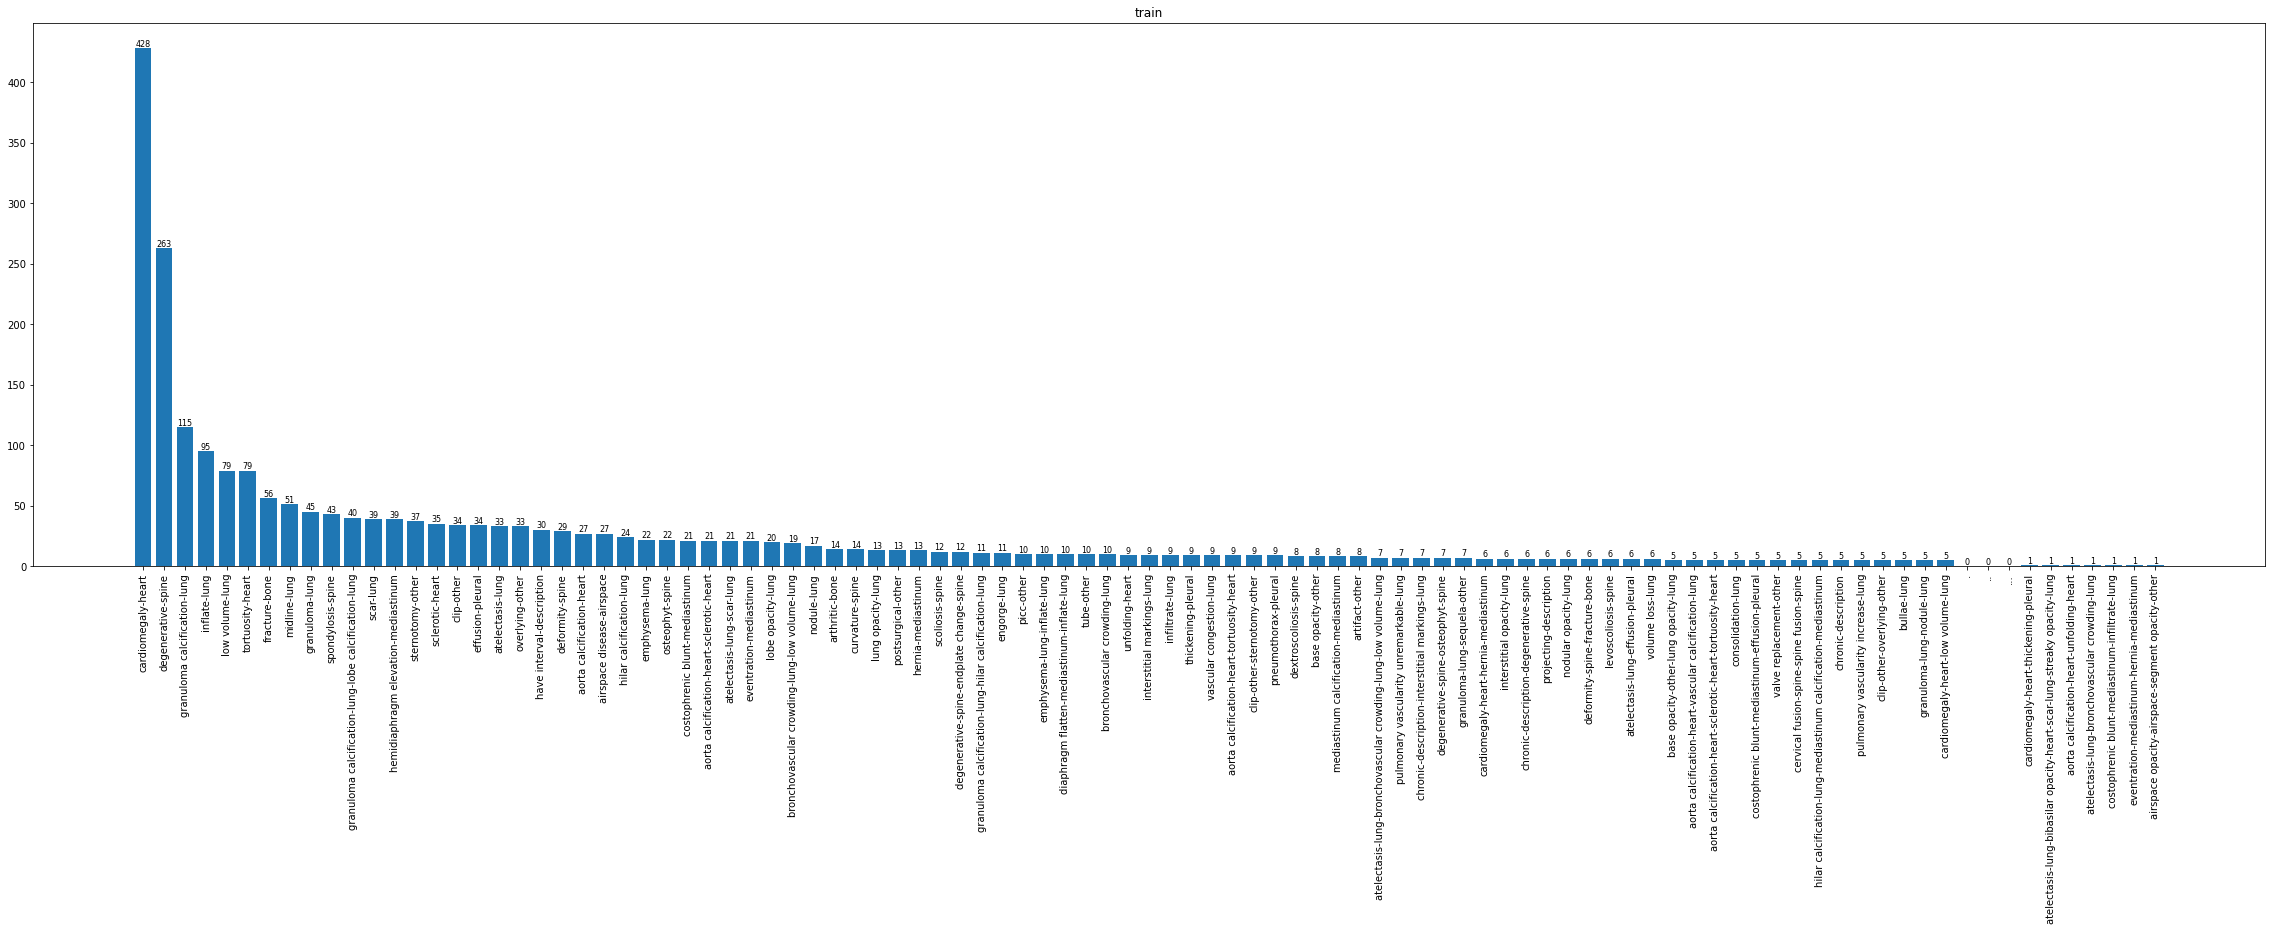

In [55]:
plot_disease(disease_histogram_sent_no_order(train_df), 'train')

## Data Augmentation

Goal：Incease the number of special diseases in the set

Details：augment the diseases appears more than 5 times and less than 100 times

Method：

1. Replace sentence by those which contains the same diseases form sentence pool

2. Randomly delete normal description sentence

3. Randomly repete sentence containing diseases


In [56]:
import copy
import random

In [57]:
train_df['aug_type'] = 'None'
train_df['unique_id'] = train_df['id']
train_df['report_aug'] = train_df['report']
train_df['split_by_sentence_aug'] = train_df['split_by_sentence']

In [58]:
def find_target_vocab(input_set, lower_limit, upper_limit, ignore_key=[]):
    for k in input_set:
        if k in ignore_key:
            continue
        if input_set[k] >= lower_limit and input_set[k] <= upper_limit // 2:
            return k
    print('All elements > %f' % lower_limit)
    return -1

In [59]:
# count each disease
def count_disease_ascend(disease_list):    
    disease_description_count = {}
    for disease in disease_list:
        if disease not in disease_description_count:
            disease_description_count[disease] = 1
        else:
            disease_description_count[disease] += 1
    # sort the dict
    sorted_disease_description_count = {k: v for k, v in \
                                        sorted(disease_description_count.items(), \
                                        key=lambda item: item[1], reverse=False)}
    return sorted_disease_description_count

In [60]:
def augmentation_to_count(df, LOWER_TIMES_BOUND, UPPER_TIMES_BOUND):
    dataframe = df.copy(deep=True)
    
    curr_vocab_set = disease_histogram_asc(dataframe)
    ignore_key = [k for k in curr_vocab_set if curr_vocab_set[k] < LOWER_TIMES_BOUND]
    
    while 1:
        # Find target disease to augment
        curr_vocab_set = disease_histogram_asc(dataframe)
        target_disease = find_target_vocab(curr_vocab_set, LOWER_TIMES_BOUND, \
                                           UPPER_TIMES_BOUND, ignore_key)
        # Don't want augment same disease again
        ignore_key.append(target_disease)
        if target_disease == -1:
            break
        
        # Find all reports that contains target disease
        target_report_idx = []
        for i in range(len(dataframe)):
            curr_report = dataframe.iloc[i]
            if curr_report['has_disease']:
                for curr_d in curr_report['diseases_list']:
                    for d in curr_d:
                        if d == target_disease:
                            target_report_idx.append(i)

        # For each report, do augmentation
        augment_max = UPPER_TIMES_BOUND // len(target_report_idx) - 1
        #if augment_max <= 0:
        #    augment_max += 1
        #if augment_max == 0:
        #    break
        print('%s need repeat %d times' % (target_disease, augment_max))
        for ti in target_report_idx:
            # Locate disease type and sentence
            target_report = dataframe.iloc[ti]
            found = False
            for i, d_list in enumerate(target_report['diseases_list']):
                for j, d in enumerate(d_list):
                    if d == target_disease:
                        found = True
                        break
                if found:
                    break
            target_sentence = target_report['split_by_sentence'][i]
            target_disease_type = target_report['disease_type'][i][j]

            # Find available sentences
            replace_sentence_pool = diseases_pool[target_disease_type]
            enough_pool = True
            if len(replace_sentence_pool) - 1 < augment_max:
                enough_pool = False
                # If not enough similar sentences, replace all possible and repeat
                #repeat_time = UPPER_TIMES_BOUND - (augment_max + 1) * len(target_report_idx)
                #repeat_time = repeat_time // len(target_report_idx) + 1
                #for _ in range(repeat_time):
                #    dataframe = dataframe.append(target_report)

            # Then augmentation from the pool:
            # If enough similar sentences, replace target sentence randomly
            # Else, replace all possible
            for ori_idx in range(len(replace_sentence_pool)):
                if replace_sentence_pool[ori_idx] == target_sentence:
                    break
            sample_list = list(range(len(replace_sentence_pool)))
            sample_list.remove(ori_idx)
            if not enough_pool:
                augment_max = len(sample_list)
            random_replace_sentence_idx = random.sample(sample_list, augment_max)
            for ri in random_replace_sentence_idx:
                new_report = target_report.copy()
                new_report['split_by_sentence'][i] = replace_sentence_pool[ri]
                new_report_str = ""
                for s in new_report['split_by_sentence']:
                    new_report_str += s + ". "
                new_report_str = new_report_str[:-2]
                new_report['report'] = new_report_str
                dataframe = dataframe.append(new_report)


    return dataframe

In [61]:
def find_report_sent_disease(report, idx):
    total_d = []
    for sd in report['disease_type'][idx]:
        if len(sd) == 0:
            continue
        total_d.append(sd)
    total_d_str = ""
    total_d.sort()
    for d in total_d:
        total_d_str += d + '-'
    total_d_str = total_d_str[:-1]
    return total_d_str

def augmentation_to_count_sent(df, LOWER_TIMES_BOUND, UPPER_TIMES_BOUND):
    dataframe = df.copy(deep=True)
    
    curr_vocab_set = disease_histogram_sent_no_order_asc(dataframe)
    ignore_key = [k for k in curr_vocab_set if curr_vocab_set[k] < LOWER_TIMES_BOUND]
    
    while 1:
        # Find target disease to augment
        curr_vocab_set = disease_histogram_sent_no_order_asc(dataframe)
        target_disease = find_target_vocab(curr_vocab_set, LOWER_TIMES_BOUND, \
                                           UPPER_TIMES_BOUND, ignore_key)
        if target_disease == -1:
            break
        # Don't want augment same disease again
        ignore_key.append(target_disease)
        
        # Find all reports that contains target disease
        target_report_idx = []
        for i in range(len(dataframe)):
            curr_report = dataframe.iloc[i]
            for j in range(len(curr_report['split_by_sentence'])):
                curr_sent_disease = find_report_sent_disease(curr_report, j)
                if curr_sent_disease == target_disease:
                    target_report_idx.append(i)

        # For each report, do augmentation
        augment_max = UPPER_TIMES_BOUND // len(target_report_idx) - 1
        print('%s need repeat %d times' % (target_disease, augment_max))
        for ti in target_report_idx:
            # Locate disease type and sentence
            target_report = dataframe.iloc[ti]
            
            found = False
            for i in range(len(curr_report['split_by_sentence'])):
                curr_sent_disease = find_report_sent_disease(target_report, i)
                if curr_sent_disease == target_disease:
                    found = True
                    break
            target_sentence = target_report['split_by_sentence'][i]
                   
            # Find available sentences
            replace_sentence_pool = sent_disease_pool[target_disease]
            enough_pool = True
            if len(replace_sentence_pool) - 1 < augment_max:
                enough_pool = False
                # If not enough similar sentences, replace all possible and repeat
                #repeat_time = UPPER_TIMES_BOUND - (augment_max + 1) * len(target_report_idx)
                #repeat_time = repeat_time // len(target_report_idx) + 1
                #for _ in range(repeat_time):
                #    dataframe = dataframe.append(target_report)

            # Then augmentation from the pool:
            # If enough similar sentences, replace target sentence randomly
            # Else, replace all possible
            for ori_idx in range(len(replace_sentence_pool)):
                if replace_sentence_pool[ori_idx] == target_sentence:
                    break
            sample_list = list(range(len(replace_sentence_pool)))
            sample_list.remove(ori_idx)
            if not enough_pool:
                augment_max = len(sample_list)
            random_replace_sentence_idx = random.sample(sample_list, augment_max)
            for ri in random_replace_sentence_idx:
                new_report = target_report.copy()
                new_report['split_by_sentence'][i] = replace_sentence_pool[ri]
                new_report_str = ""
                for s in new_report['split_by_sentence']:
                    new_report_str += s + ". "
                new_report_str = new_report_str[:-2]
                new_report['report'] = new_report_str
                dataframe = dataframe.append(new_report)


    return dataframe

In [62]:
len(train_df)

2069

In [63]:
RANDOM_SEED = 0

LOWER_TIMES_BOUND = 5
UPPER_TIMES_BOUND = 100
df_aug = augmentation_to_count_sent(train_df,  LOWER_TIMES_BOUND, UPPER_TIMES_BOUND)

base opacity-other-lung opacity-lung need repeat 19 times
aorta calcification-heart-vascular calcification-lung need repeat 19 times
aorta calcification-heart-sclerotic-heart-tortuosity-heart need repeat 19 times
consolidation-lung need repeat 19 times
costophrenic blunt-mediastinum-effusion-pleural need repeat 19 times
valve replacement-other need repeat 19 times
cervical fusion-spine-spine fusion-spine need repeat 19 times
hilar calcification-lung-mediastinum calcification-mediastinum need repeat 19 times
chronic-description need repeat 19 times
pulmonary vascularity increase-lung need repeat 19 times
clip-other-overlying-other need repeat 19 times
bullae-lung need repeat 19 times
granuloma-lung-nodule-lung need repeat 19 times
cardiomegaly-heart-low volume-lung need repeat 19 times
cardiomegaly-heart-hernia-mediastinum need repeat 15 times
chronic-description-degenerative-spine need repeat 15 times
projecting-description need repeat 15 times
nodular opacity-lung need repeat 15 times

In [64]:
len(df_aug)

4980

## Disease statistics & Sentence statistics
Codes for generating Figure 1 in our paper

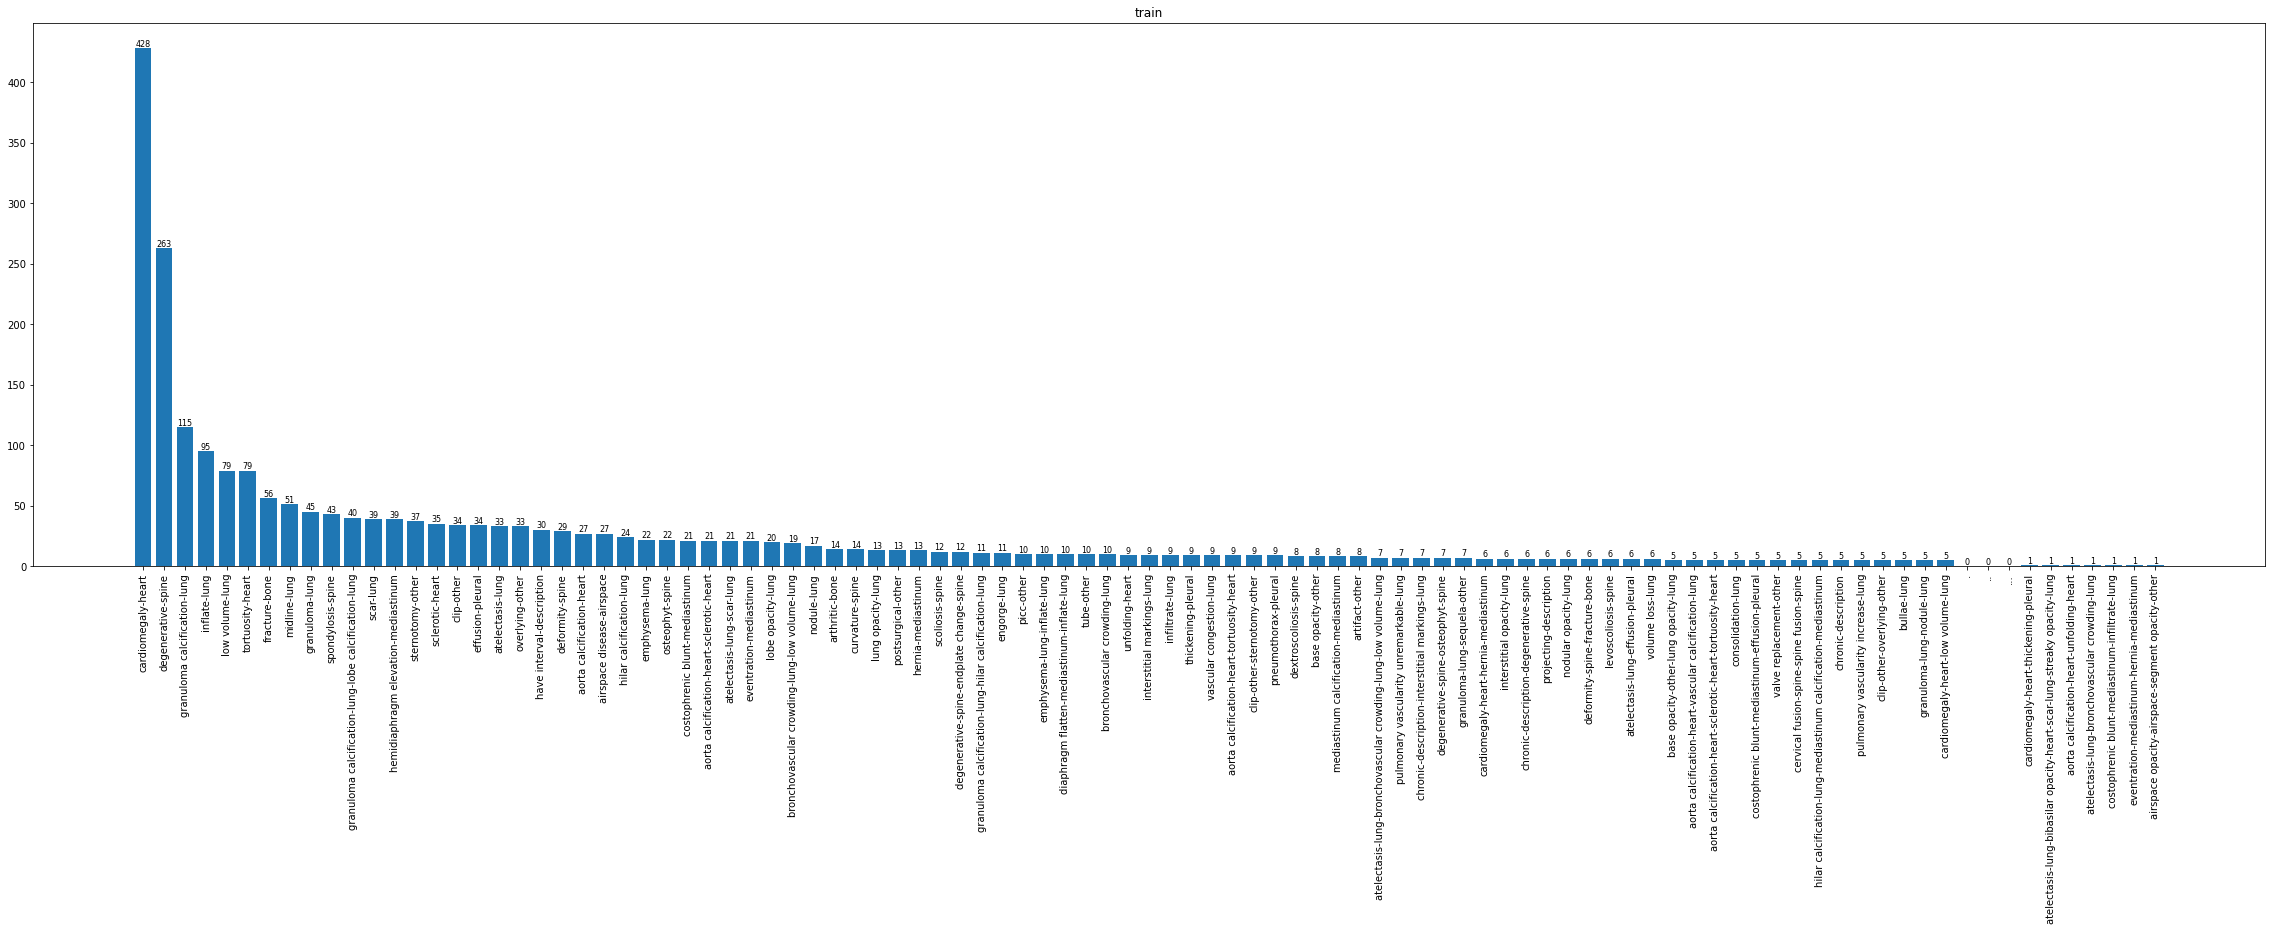

In [65]:
# train
plot_disease(disease_histogram_sent_no_order(train_df), 'train', min_value=-1)

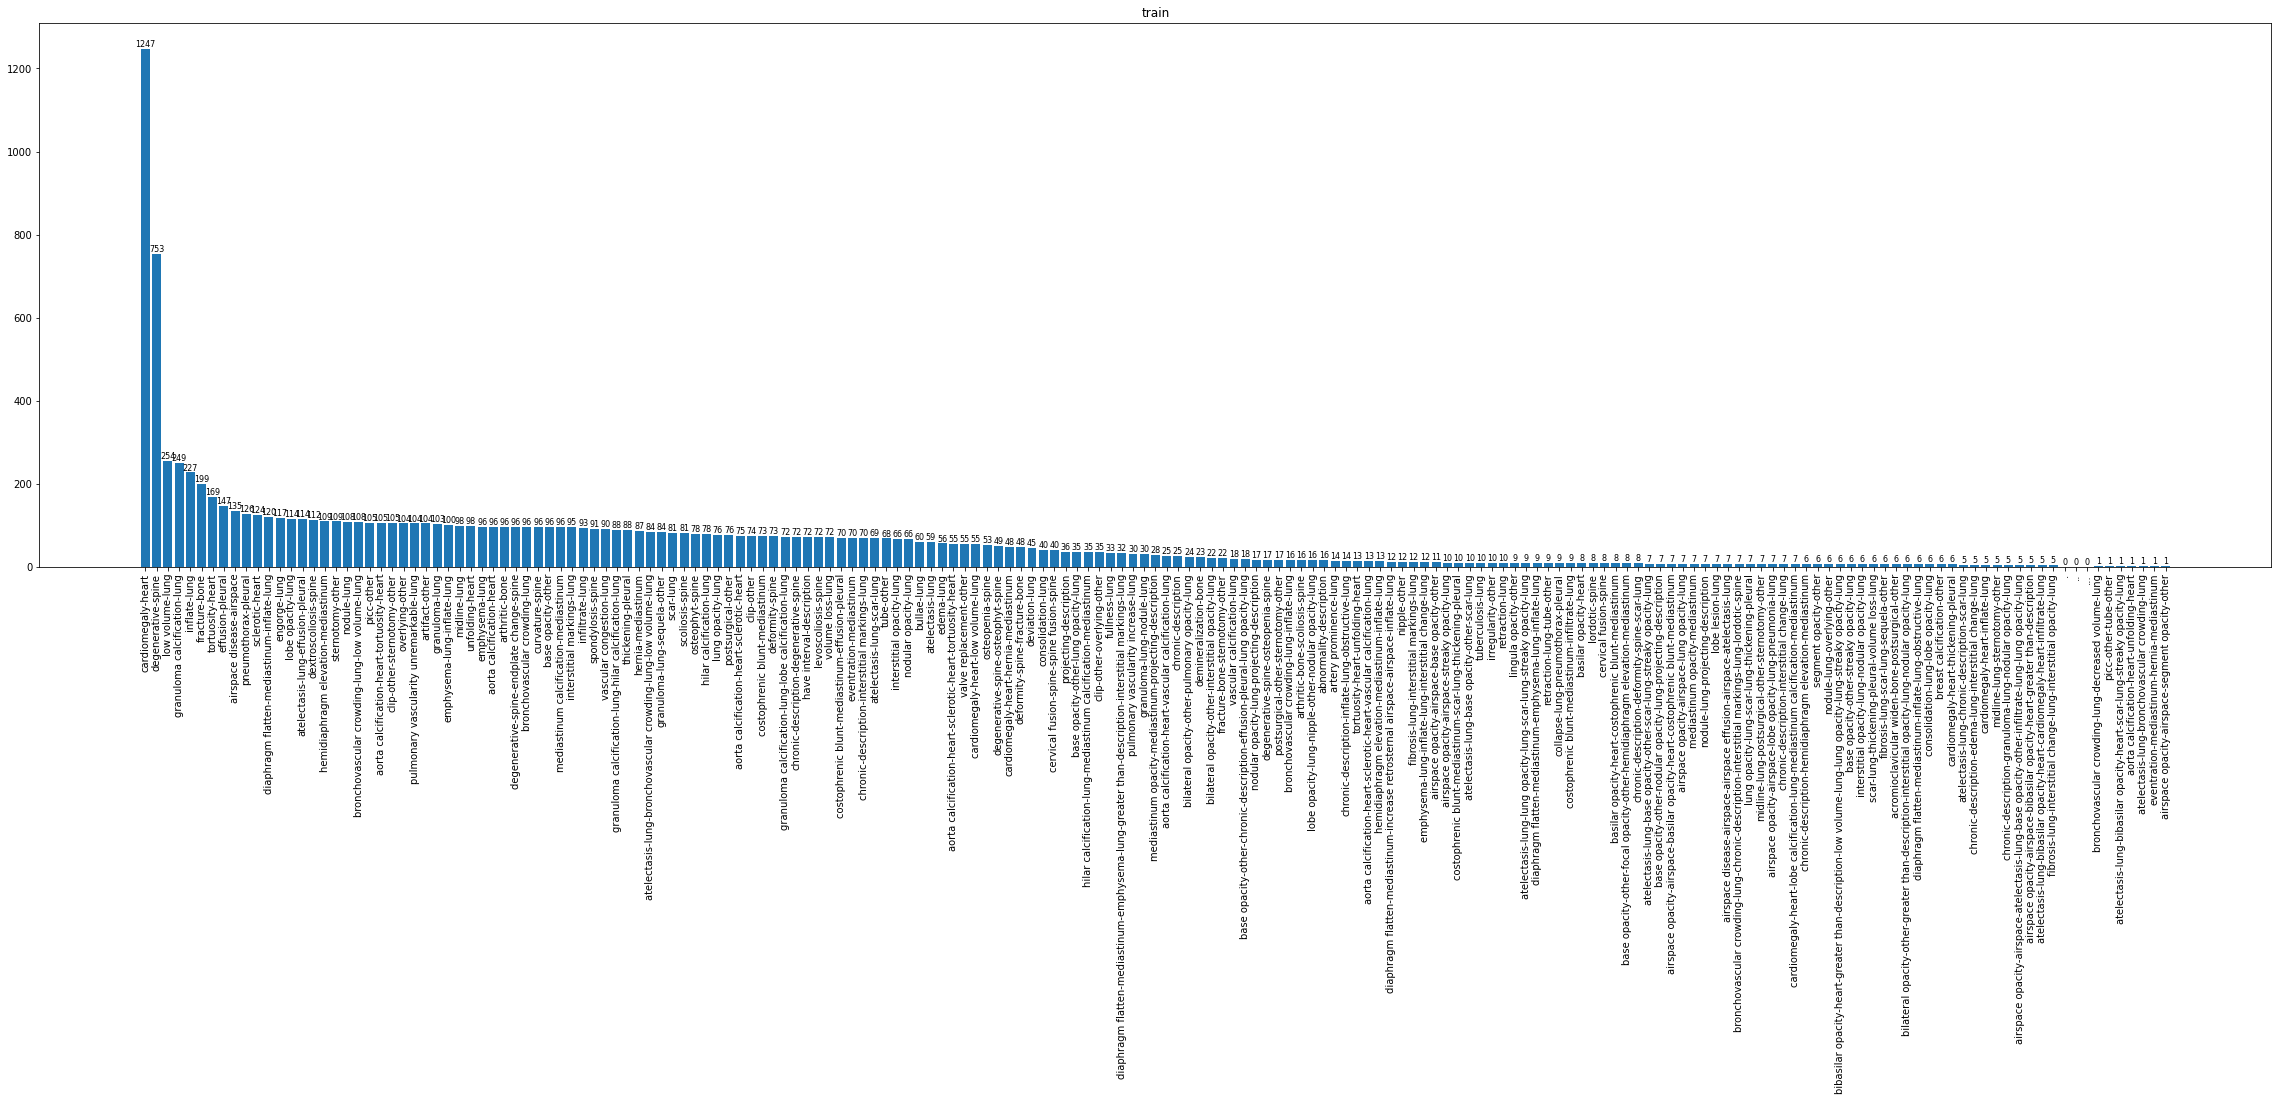

In [66]:
plot_disease(disease_histogram_sent_no_order(df_aug), 'train', min_value=-1)

In [67]:
def plot_disease_together(sorted_disease_description_count, sorted_disease_description_count_aug, mode, min_value=-1):

    tmp = {k:sorted_disease_description_count[k] for k in sorted_disease_description_count \
           if sorted_disease_description_count[k] > min_value}
    
    tmp_aug = {k:sorted_disease_description_count_aug[k] for k in sorted_disease_description_count_aug \
           if sorted_disease_description_count_aug[k] > min_value}
    
    keys_ = list(tmp.keys())
    values_ = list(tmp.values())
#     keys_aug_ = list(tmp_aug.keys())
#     values_aug = list(tmp_aug.values())
    
    keys = []
    values = []
    values_aug = []
    unique_key = []
    
    count = 0
    
    for i in range(len(keys_)):
        value = values_[i]
        key = keys_[i]
        if value < 5 and len(keys_) - i > 5:
            count += 1
            if count < 4:
                values.append(0)
                keys.append('.'*count)
                values_aug.append(0)
            pass
        else:
            values.append(value)
            adj_key_list = key.split('-')
            adj_key = ''
            for k in adj_key_list:
                adj_key += k[:4]
                adj_key += '-'
            if len(adj_key) > 15:
                adj_key = adj_key[:15]
                
            trf = True
            while trf:
                if adj_key in unique_key:
                    adj_key += '.'
                else:
                    trf = False
                
            unique_key.append(adj_key)
            keys.append(adj_key)
            values_aug.append(tmp_aug[key])
#             keys.append(key)
    
    
    plt.figure(figsize=(40, 10))
    plt.bar(keys, values, color='steelblue', label='original training data')
    plt.bar(keys, values_aug, bottom=values, color='skyblue', label='training data after augmentation')
    plt.xticks(rotation=90, fontsize=17)
    plt.yticks(fontsize=17)

    for a,b, c in zip(keys,values, values_aug):
        plt.text(a, b-0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=12)
        plt.text(a, b+c+0.05, '%.0f' % c, ha='center', va= 'bottom',fontsize=12)

    plt.xlabel('Diseases Statistics', labelpad=15, fontsize = 20)
    plt.ylabel('Counts', labelpad=15, fontsize = 20)
    plt.legend()
    plt.savefig('./stas_train.tif',dpi=800,format='tif', bbox_inches='tight')


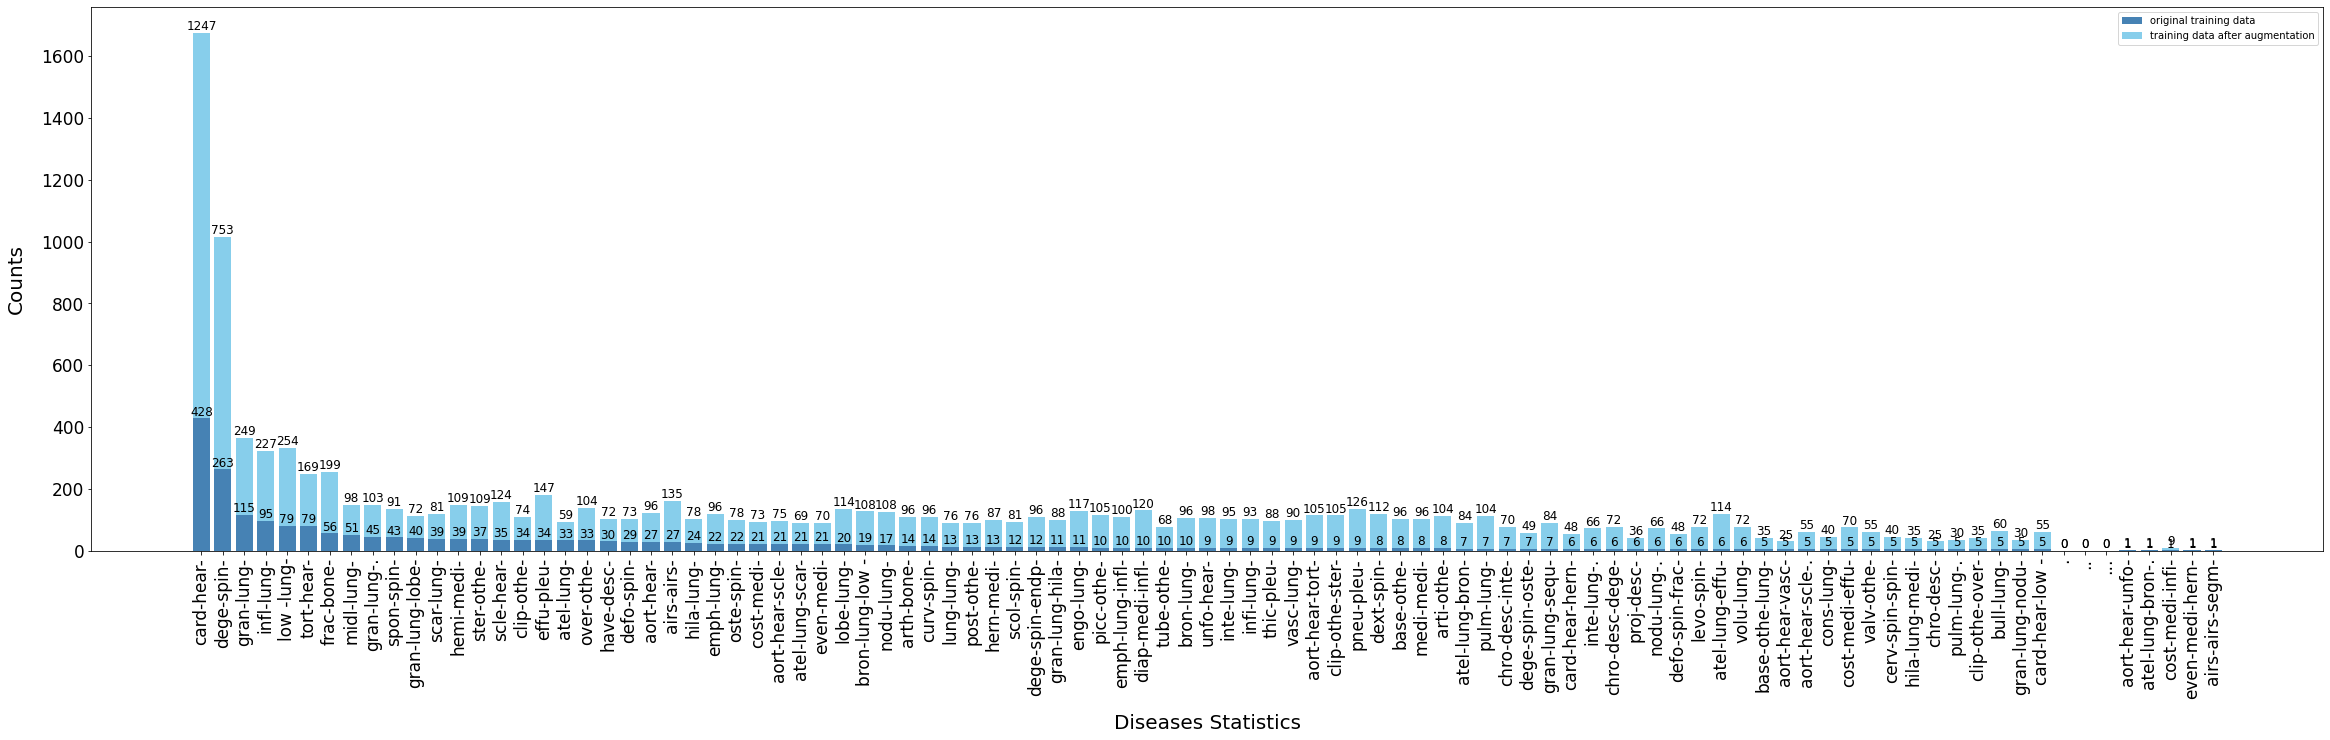

In [68]:
plot_disease_together(disease_histogram_sent_no_order(train_df),
                      disease_histogram_sent_no_order(df_aug), 'train', min_value=-1)

In [69]:
ori_count = disease_histogram_sent_no_order(train_df)
aug_count = disease_histogram_sent_no_order(df_aug)

In [70]:
def increase_ratio(ori_count, aug_count):
    ori_total_count = 0
    aug_total_count = 0
    ori_common_count = 0
    aug_common_count = 0
    ori_tail_count = 0
    aug_tail_count = 0
    
    for disease in ori_count:
        if ori_count[disease] > 20:
            ori_common_count += ori_count[disease]
            aug_common_count += aug_count[disease]
        else:
            ori_tail_count += ori_count[disease]
            aug_tail_count += aug_count[disease]
            
        ori_total_count += ori_count[disease]
        aug_total_count += aug_count[disease]
    
    print(f"common ori ratio: {ori_common_count / ori_total_count}, after aug, common ratio: {aug_common_count / aug_total_count}")
    print(f"tail ori ratio: {ori_tail_count / ori_total_count}, after aug, tail ratio: {aug_tail_count / aug_total_count}")
    print(f"the ratio of common disease in ori over in aug: {aug_common_count / ori_common_count}")
    print(f"the ratio of tail disease in ori over in aug: {aug_tail_count / ori_tail_count}")
    

In [71]:
increase_ratio(ori_count, aug_count)

common ori ratio: 0.6516973125884017, after aug, common ratio: 0.47097301717089124
tail ori ratio: 0.3483026874115983, after aug, tail ratio: 0.5290269828291088
the ratio of common disease in ori over in aug: 2.812805208898535
the ratio of tail disease in ori over in aug: 5.911675126903553


In [72]:
temp = disease_histogram_sent_no_order(train_df)

In [73]:
count_com = 0
count_spe = 0

for key in temp:
    c = temp[key]
    if c > 5:
        count_com += c
    else:
        count_spe += c


In [74]:
disease_free_sen = 0
for i in range(len(train_df)):
    item = train_df.iloc[i]
    disease_list = item['diseases_list']
    for diseases in disease_list:
        if len(diseases) == 0:
            disease_free_sen += 1

In [75]:
keys = ['d_free', 'd_com', 'd_tail']
values = [disease_free_sen, count_com, count_spe]

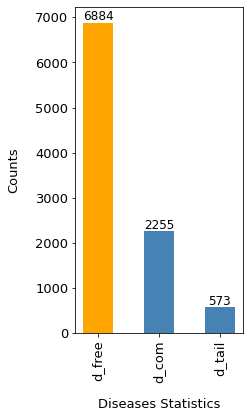

In [76]:
plt.figure(figsize=(3, 6))
plt.bar(keys, values, width=0.5, color=['orange', 'steelblue', 'steelblue'])
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=13)

for a,b in zip(keys,values):
    plt.text(a, b-0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=12)

plt.xlabel('Diseases Statistics', labelpad=15, fontsize = 13)
plt.ylabel('Counts', labelpad=15, fontsize = 13)
# plt.legend(prop={'size': 13})
plt.savefig('./stas_train_summary.tif',dpi=800,format='tif', bbox_inches='tight')

## Evaluation

Given two report sets (prediction and groundtruth), evaluation_new() can be utilized to obtain the DOR and DS scores.

In [77]:
def find_organ_and_disease(report):
    return find_diseases_organs(clean_sentence(divide_to_sentences(report)))

def evaluation_new(pred_report, gt_report, select_idx=None):
    pred_organ, pred_disease_all = find_organ_and_disease(pred_report)
    gt_organ, gt_disease_all = find_organ_and_disease(gt_report)
    num_case = len(pred)
    
    # Statitics Compute
    tp,fp1,fp2,tn,fn = 0,0,0,0,0
    pred_pool = []
    for i in range(num_case):
        if select_idx is not None:
            if i not in select_idx:
                continue
        gt = gt_disease_all[i]
        pre = pred_disease_all[i]

        gt_list = []
        pre_list = []
        for gt_disease in gt:
            gt_list.extend(gt_disease)
        for pre_disease in pre:
            pre_list.extend(pre_disease)
            
        
        set_gt = set(gt_list)
        set_pre = set(pre_list)
    
        
        if len(gt_list) == 0:
            if len(pre_list) == 0:
                tn += 1
            # pred disease, gt no disease -> fp type 1
            else:
                fp1 += 1
        else:
            # pred no disease, gt disease -> fn
            if len(pre_list) == 0:
                fn += 1
            else:
                found = False
                for p in pre_list:
                    if p in gt_list:
                        found = True
                        pred_pool.append(p)
                # pred disease, gt same disease -> tp
                if found:
                    tp += 1
                # pred disease, gt another disease -> fp type 2
                else:
                    fp2 += 1
                    
    # Diversity Check
    diversity = 0
    for i in range(num_case):
        gt = gt_disease_all[i]
        gt_list = []
        for gt_disease in gt:
            gt_list.extend(gt_disease)
        
        find = False
        for g in gt_list:
            if g in pred_pool:
                find = True
        
        if find:
            diversity += 1
        
    print(tp)
    print(diversity)
    
    # Compute Diverse TP  
    if tp+diversity == 0:
        dtp = 0
    else:
        dtp = (2*tp*diversity) / ((tp+diversity)*num_case)
    
    # Compute DOR
    # not used b/c encounter divide by 0
    #dor = tp * tn / (fp1+fp2) / fn 
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp1+fp2)
    dor = (tpr+tnr) / 2.0
    
    print(tp)
    print(fp1)
    print(fp2)
    print(tn)
    print(fn)
    
    return dtp, dor

In [78]:
result = pd.read_excel('../report_bleubest.xlsx')
pred = result['our_prediction'][:-1]
gt = result['ground_truth'][:-1]
print(evaluation_new(pred, gt))

11
72
11
10
43
264
261
(0.03240125186654939, 0.4366243737242531)


In [79]:
result_cls = pd.read_excel('../report_full_aug.xlsx')
pred = result_cls['our_prediction'][:-1]
gt = result_cls['ground_truth'][:-1]
print(evaluation_new(pred, gt))

86
254
86
272
228
2
1
(0.2181563966843104, 0.49624490543572836)
